# Backtestを行うNotebookのサンプル
このNotebookでは、例としてMANAUSDTをBINANCE FUTUREにて自動売買を行うbotのロジックとそのバックテストの実施方法について必要最低限にまとめています。

## 必要なライブラリのインポート
以下のコードで必要なライブラリをインポート

In [17]:
import math

import ccxt
from crypto_data_fetcher.binance_future import BinanceFutureFetcher
import joblib
import matplotlib.pyplot as plt
import numba
import numpy as np
import pandas as pd
from scipy.stats import ttest_1samp
import seaborn as sns
import talib
from datetime import datetime, timedelta


### ohlcvファイルを取得

In [82]:
fetcher = BinanceFutureFetcher(ccxt_client=binance)

df = fetcher.fetch_ohlcv(
    market='MANAUSDT', # 市場のシンボルを指定
    interval_sec=30 * 60, # 足の間隔を秒単位で指定。この場合は30分足
)

# 実験に使うデータ期間を限定する (今回の例では2022年の1月1日から)
# df = df[df.index < pd.to_datetime('2023-01-01 00:00:00Z')]
df = df[ pd.to_datetime('2022-01-01 00:00:00Z') < df.index]

display(df)
df.to_pickle('df_ohlcv.pkl')

,op,hi,lo,cl,volume
timestamp,,,,,
2022-01-01 00:30:00+00:00,3.2867,3.3231,3.2783,3.3164,2383880.0
2022-01-01 01:00:00+00:00,3.3164,3.3246,3.2959,3.3173,2039983.0
2022-01-01 01:30:00+00:00,3.3175,3.3184,3.2955,3.2994,1145030.0
2022-01-01 02:00:00+00:00,3.2995,3.3132,3.2982,3.3069,977482.0
2022-01-01 02:30:00+00:00,3.3069,3.3150,3.2959,3.3006,1458542.0
...,...,...,...,...,...
2023-02-18 08:00:00+00:00,0.7189,0.7195,0.7155,0.7191,2274136.0
2023-02-18 08:30:00+00:00,0.7191,0.7196,0.7157,0.7179,1762123.0
2023-02-18 09:00:00+00:00,0.7180,0.7200,0.7159,0.7182,1259283.0


## taker手数料[%]カラムを設定

以下のコードでは、Taker手数料カラムを追加する。

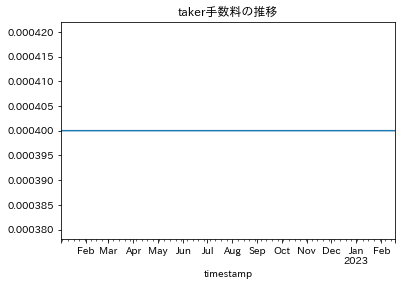

,op,hi,lo,cl,volume,fee
timestamp,,,,,,
2022-01-01 00:30:00+00:00,3.2867,3.3231,3.2783,3.3164,2383880.0,0.0004
2022-01-01 01:00:00+00:00,3.3164,3.3246,3.2959,3.3173,2039983.0,0.0004
2022-01-01 01:30:00+00:00,3.3175,3.3184,3.2955,3.2994,1145030.0,0.0004
2022-01-01 02:00:00+00:00,3.2995,3.3132,3.2982,3.3069,977482.0,0.0004
2022-01-01 02:30:00+00:00,3.3069,3.3150,3.2959,3.3006,1458542.0,0.0004
...,...,...,...,...,...,...
2023-02-18 07:00:00+00:00,0.7253,0.7253,0.7192,0.7212,4013282.0,0.0004
2023-02-18 07:30:00+00:00,0.7213,0.7225,0.7153,0.7188,3340295.0,0.0004
2023-02-18 08:00:00+00:00,0.7189,0.7195,0.7155,0.7191,2274136.0,0.0004


In [60]:
#　途中で手数料が代わったり、本配列に変更日時と手数料を追加していく。
taker_fee_history = [
    {
        'changed_at': '2021/03/15 07:00:00Z',
        'taker_fee': 0.0004 # Binanceは0.04%
    },
]

df = pd.read_pickle('df_ohlcv.pkl')

# 初期の手数料
df['fee'] = 0.0004

for config in taker_fee_history:
    df.loc[pd.to_datetime(config['changed_at']) <= df.index, 'fee'] = config['taker_fee']

df['fee'].plot()
plt.title('taker手数料の推移')
plt.show()
    
display(df)
df.to_pickle('df_ohlcv_with_fee.pkl')

## ロジック作成のための特徴量の設定

テクニカル指標計算ライブラリの[TA-Lib](https://mrjbq7.github.io/ta-lib/)を利用して特徴量を作成する。


In [81]:
def calc_features(df):
    open = df['op']
    high = df['hi']
    low = df['lo']
    close = df['cl']
    volume = df['volume']
    orig_columns = df.columns
    hilo = (df['hi'] + df['lo']) / 2
    df['diff'] = (close - close.shift(1)) / close * 100
    df['ema_diff'] = talib.EMA(df['diff'], timeperiod=10)
    df['sig'] = df['ema_diff'] - df['ema_diff'].shift(16)

    return df

df = pd.read_pickle('df_ohlcv_with_fee.pkl')
df = df.dropna()
df = calc_features(df)
display(df)
df.to_pickle('df_features.pkl')

,op,hi,lo,cl,volume,fee,diff,ema_diff,sig
timestamp,,,,,,,,,
2022-01-01 00:30:00+00:00,3.2867,3.3231,3.2783,3.3164,2383880.0,0.0004,NaN,NaN,NaN
2022-01-01 01:00:00+00:00,3.3164,3.3246,3.2959,3.3173,2039983.0,0.0004,0.027130,NaN,NaN
2022-01-01 01:30:00+00:00,3.3175,3.3184,3.2955,3.2994,1145030.0,0.0004,-0.542523,NaN,NaN
2022-01-01 02:00:00+00:00,3.2995,3.3132,3.2982,3.3069,977482.0,0.0004,0.226799,NaN,NaN
2022-01-01 02:30:00+00:00,3.3069,3.3150,3.2959,3.3006,1458542.0,0.0004,-0.190874,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2023-02-18 07:00:00+00:00,0.7253,0.7253,0.7192,0.7212,4013282.0,0.0004,-0.554631,-0.148213,-0.118748
2023-02-18 07:30:00+00:00,0.7213,0.7225,0.7153,0.7188,3340295.0,0.0004,-0.333890,-0.181973,-0.155322
2023-02-18 08:00:00+00:00,0.7189,0.7195,0.7155,0.7191,2274136.0,0.0004,0.041719,-0.141302,-0.323137


## バックテストを行うコード
以下はMANAを30分足で成行で取引するロジック（現状longでのみうまくいっており、ここ数年のshortの結果は悪い。）

Return Sum


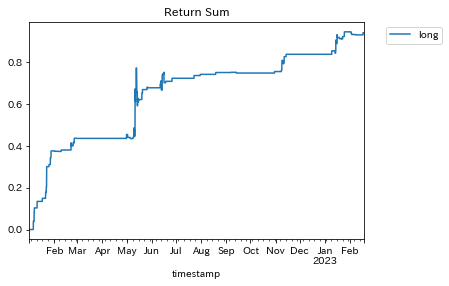

In [83]:
@numba.njit
def calc_force_entry_price(entry_price=None, lo=None, pips=None):
    y = entry_price.copy()
    y[:] = np.nan
    force_entry_time = entry_price.copy()
    force_entry_time[:] = np.nan
    for i in range(entry_price.size):
        for j in range(i + 1, entry_price.size):
            if round(lo[j] / pips) < round(entry_price[j - 1] / pips):
                y[i] = entry_price[j - 1]
                force_entry_time[i] = j - i
                break
    return y, force_entry_time

df = pd.read_pickle('df_features.pkl')

# 呼び値 (取引所、取引ペアごとに異なる)
pips = 0.0001

#エントリーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーー
#以下の条件分岐に該当するかを0, 1で返す。

df['buy_entry'] = ((df['sig'] < (-10/10)) & (df['sig'].shift(1) > (-10/10))).astype('float64')
df['sell_entry'] = ((df['sig'] > (8/10)) & (df['sig'].shift(1) < (8/10))).astype('float64')

df['entry_buy_price'] = np.where(
    df['buy_entry'],
    df['op'].shift(-1), 
#     df['cl']-pips, 
    0,
)

df['entry_sell_price'] = np.where(
    df['sell_entry'],
    df['op'].shift(-1),
#     df['cl']+pips,
    1000000,
)
# Force Entry Priceの計算

df['buy_fep'], df['buy_fet'] = calc_force_entry_price(
    entry_price=df['entry_buy_price'].values,
    lo=df['lo'].values,
    pips=pips,
)

# calc_force_entry_priceは入力と出力をマイナスにすれば売りに使えます
df['sell_fep'], df['sell_fet'] = calc_force_entry_price(
    entry_price=-df['entry_sell_price'].values,
    lo=-df['hi'].values, # 売りのときは高値
    pips=pips,
)

df['sell_fep'] *= -1

#エグジットーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーー

df['buy_exit'] = ((df['sig'] < (7/10)) & (df['sig'].shift(1) > (7/10))).astype('float64')
df['sell_exit'] = ((df['sig'] > (-7/10)) & (df['sig'].shift(1) < (7/10))).astype('float64')

df['exit_buy_price'] = np.where(
    df['buy_exit'],
    df['op'].shift(-1),
    0,
)

df['exit_sell_price'] = np.where(
    df['sell_exit'],
    df['op'].shift(-1),
    1000000,
)

# Force Exit Priceの計算
df['exit_buy_fep'], df['exit_buy_fet'] = calc_force_entry_price(
    entry_price=df['exit_buy_price'].values,
    lo=df['lo'].values,
    pips=pips,
)

# calc_force_entry_priceは入力と出力をマイナスにすれば売りに使えます
df['exit_sell_fep'], df['exit_sell_fet'] = calc_force_entry_price(
    entry_price=-df['exit_sell_price'].values,
    lo=-df['hi'].values, # 売りのときは高値
    pips=pips,
)
df['exit_sell_fep'] *= -1
#ーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーー



horizon = 1 # エントリーしてからエグジットを始めるまでの待ち時間 (1以上である必要）
fee = df['fee'].values # maker手数料

# ロジックの部分　以下の条件に該当するかどうか (0, 1)
df['buy_executed'] = ((df['entry_buy_price'] / pips).round() > (df['lo'].shift(-1) / pips).round()).astype('float64')
df['sell_executed'] = ((df['entry_sell_price'] / pips).round() < (df['hi'].shift(-1) / pips).round()).astype('float64')


# yを計算
df['y_long'] = np.where(
    df['buy_executed'],
    df['exit_sell_fep'].shift(-horizon) / df['entry_buy_price'] - 1 - 2 * fee,
    0
)

df['y_short'] = np.where(
    df['sell_executed'],
    -(df['exit_buy_fep'].shift(-horizon) / df['entry_sell_price'] - 1) - 2 * fee,
    0
)


print('Return Sum')

df['y_long'].cumsum().plot(label='long')
# df['y_short'].cumsum().plot(label='short')
# (df['y_long'] + df['y_short']).cumsum().plot(label='sum')

plt.title('Return Sum')
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

df.to_pickle('df_binance_y.pkl')

df.to_pickle('df_y.pkl')

本ロジックの特徴として、勝率は高いが利益率が低いので、レバレッジをかけるべき。